# Imports

In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
2
NVIDIA GeForce RTX 3090


In [2]:
from orbit_generation.constants import EM_MU
from orbit_generation.data import TSFeatureWiseScaler, create_dataloaders
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits, export_dynamic_orbits_html
from orbit_generation.stats import plot_histograms_comparison
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.model_factory import get_model
from orbit_generation.architectures import VAELossHistory
from orbit_generation.propagation import calculate_errors
from orbit_generation.experiment import setup_new_experiment, add_experiment_metrics
from orbit_generation.evaluation import evaluate_clustering_multiple_labels, calculate_closest_feature_distances
from orbit_generation.latent_space import plot_2d_latent_space, plot_combined_2d_latent_space, reduce_dimensions_latent_space

In [3]:
import numpy as np
import os
from pytorch_lightning import Trainer

# Parameters

In [4]:
want_to_train = True   # Set this parameter to False if you want to load the model from the folder
want_to_generate = True    # Set this parameter to False if you want to load the generation from the folder
calculate_error_metrics = True   # Set this parameter to False if you don't want to calculate any metric
want_to_generate_latent_space = True    # Set this parameter to False if you don't wan't to generate the latent space
want_to_get_cluster_metrics = True    # Set this parameter to False if you want to load the generation from the folder
want_to_study_converged_orbits = True   # Set this parameter to False if you don't want to calculate any metric

In [5]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "../experiments"

In [6]:
params = {
    'model_name': 'vae_conv5_legit',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 2,
    'feature_dim': 7,
    'seq_len': 100,
    'val_split': 0.05,
    'batch_size': 32,
    'epochs': 25,
    'beta': 0.5,
    'lr': 0.001,
    'dropout_rate': 0.2
}

# Data

## Import

In [7]:
data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

(45211, 7, 100)

Remove the time variable if specified in params

In [8]:
if params['feature_dim']==6:
    data=data[:,1:,:]
    data.shape

## Scaling

In [9]:
scaler = TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(torch.tensor(data, dtype=torch.float32))
scaled_data.shape

torch.Size([45211, 7, 100])

# Modelling

In [10]:
model = get_model(params)

In [11]:
if want_to_train:
    train_loader, val_loader = create_dataloaders(scaled_data, val_split=params.get('val_split', 0.1), batch_size=params.get('batch_size', 32))

    loss_history = VAELossHistory()

    trainer = Trainer(
        max_epochs=params.get('epochs', 10),
        log_every_n_steps=10,
        devices="auto",
        accelerator="auto",
        enable_progress_bar=True,
        enable_model_summary=True,
        callbacks=[loss_history]
    )

    trainer.fit(model, train_loader, val_loader)

    for metric_name, metric_value in trainer.callback_metrics.items():
        print(f"{metric_name}: {metric_value}")

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. T

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                  | Params | Mode 
----------------------------------------------------------------
0 | encoder       | Conv5EncoderLegitTsgm | 3.4 M  | train
1 | decoder       | Conv5DecoderLegitTsgm | 3.4 M  | train
2 | sampling      | Sampling              | 0      | train
3 | train_metrics | MetricCollection      | 0      | train
4 | val_metrics   | MetricCollection      | 0      | train
----------------------------------------------------------------
6.7 M     Trainable params
0         Non-trainable params
6.7 M     Total params
26.859    Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


val_total_loss: 3.7847437858581543
val_reconstruction_loss: 1.7084256410598755
val_kl_loss: 2.0763182640075684
train_total_loss: 4.143871307373047
train_reconstruction_loss: 1.989815354347229
train_kl_loss: 2.154055595397949


## Saving

In [12]:
experiment_folder = setup_new_experiment(params, experiments_folder)
images_folder = os.path.join(experiment_folder, 'images')
if not os.path.exists(images_folder):
    os.makedirs(images_folder)
experiment_id = os.path.basename(experiment_folder).split('_')[1]

New experiment setup complete: ../experiments/experiment_11
Parameters saved to ../experiments/experiments.json.


Define full paths for saving

In [13]:
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_orbits.npy')
static_all_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_all_generated_orbits.png')
static_some_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_some_generated_orbits.png')
dynamic_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.html')
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model.pth')
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
converged_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_converged_orbits')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
dynamical_refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')
model_losses_path = os.path.join(images_folder, f'exp{experiment_id}_model_losses.png')
histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_histogram_comparison.png')

Metrics added to experiment with ID 11 in ../experiments/experiments.json.


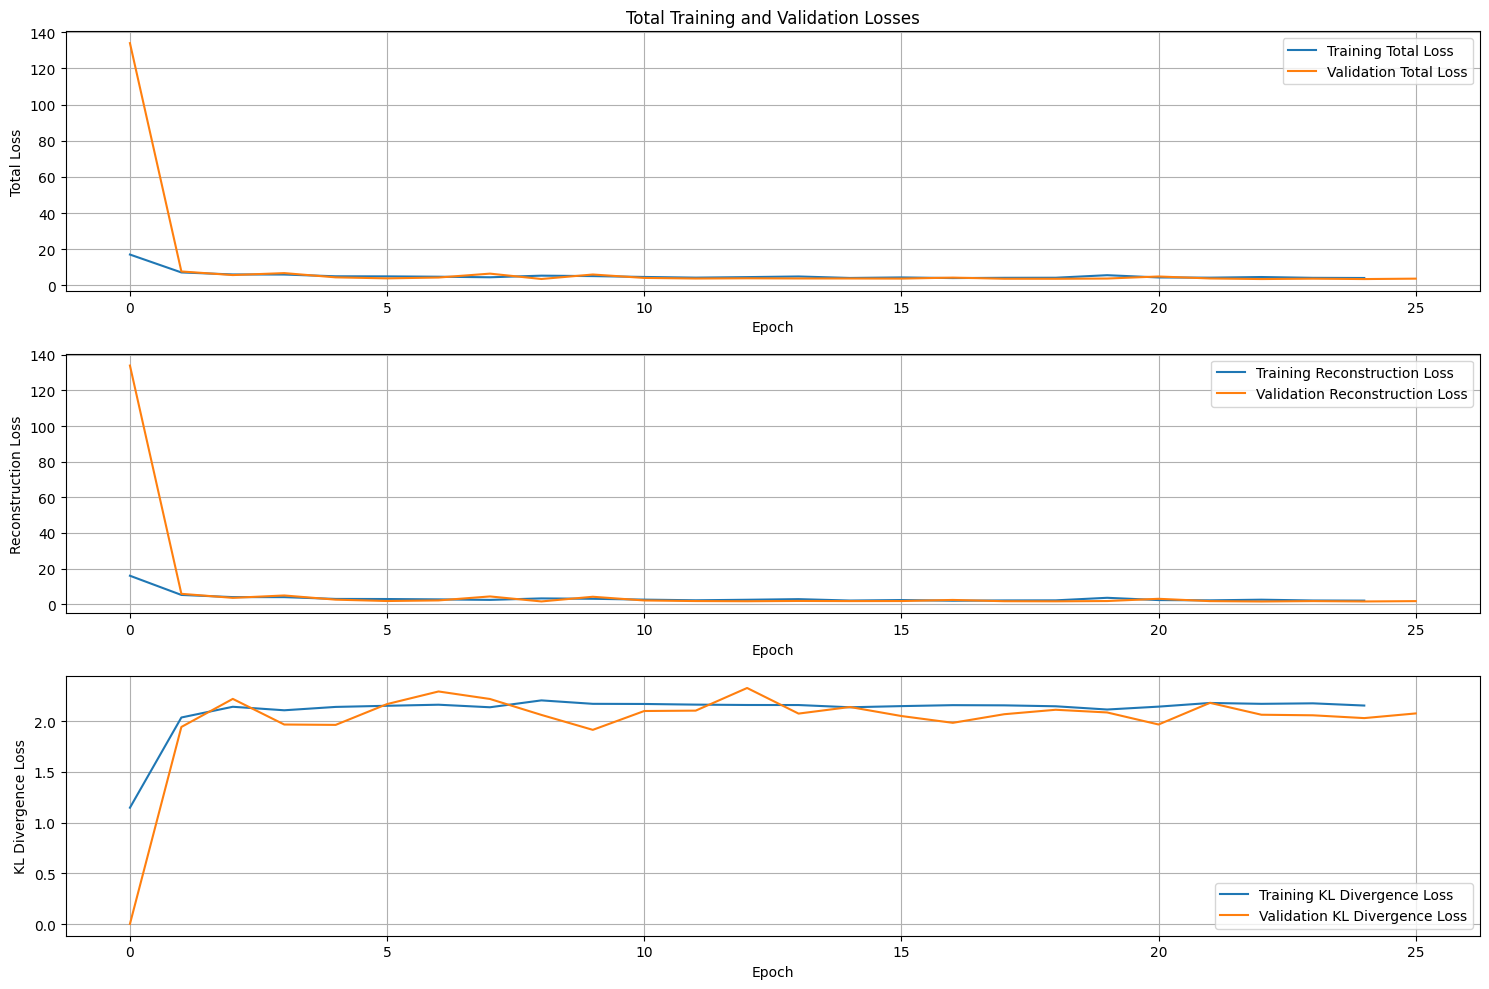

In [14]:
if want_to_train:
    add_experiment_metrics(experiments_folder, params=params, metrics=trainer.callback_metrics)
    torch.save(model.state_dict(), model_save_path)
    loss_history.plot_all_losses(save_path=model_losses_path)
else:
    model.load_state_dict(torch.load(model_save_path, weights_only=True))    

## Generate

In [ ]:
if want_to_generate:
    # Generate the orbits
    num_samples=100
    generation = model.sample(num_samples)
    generation = scaler.inverse_transform(generation)
    np.save(generated_data_path, generation.detach().numpy())
else:
    # Load the orbits
    generation = np.load(generated_data_path)

generation.shape

torch.Size([100, 7, 100])

# Analysis of Generation

## Visualization

In [16]:
if torch.is_tensor(generation):
    generation=generation.detach().numpy()

if generation.shape[1] == 7:
    no_time_generation = generation[:,1:,:]
    generation.shape
else:
    no_time_generation = generation

no_time_generation.shape

(100, 6, 100)

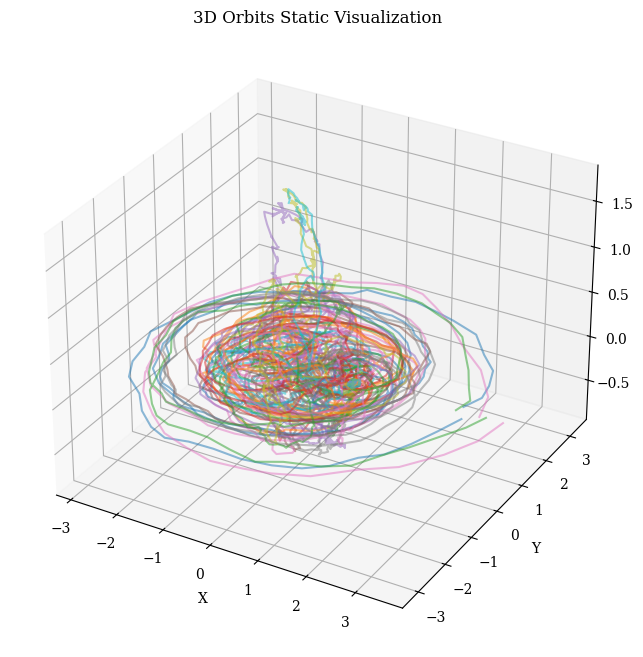

In [17]:
visualize_static_orbits(data= no_time_generation, show_legend=False, save_path=static_all_orbit_path)

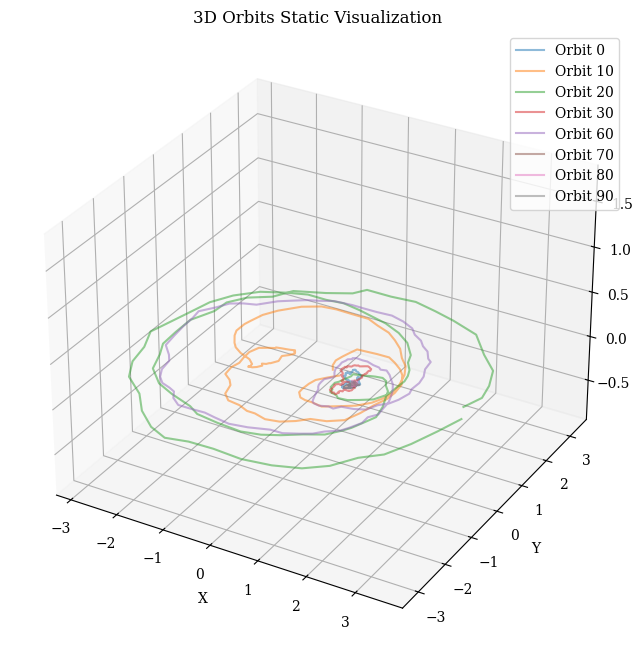

In [18]:
visualize_static_orbits(data= no_time_generation, orbit_indices=[0,10,20,30,60,70,80,90], save_path=static_some_orbit_path)

In [19]:
export_dynamic_orbits_html(data=no_time_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment_11/images/exp11_generated_orbits.html


## Coverage

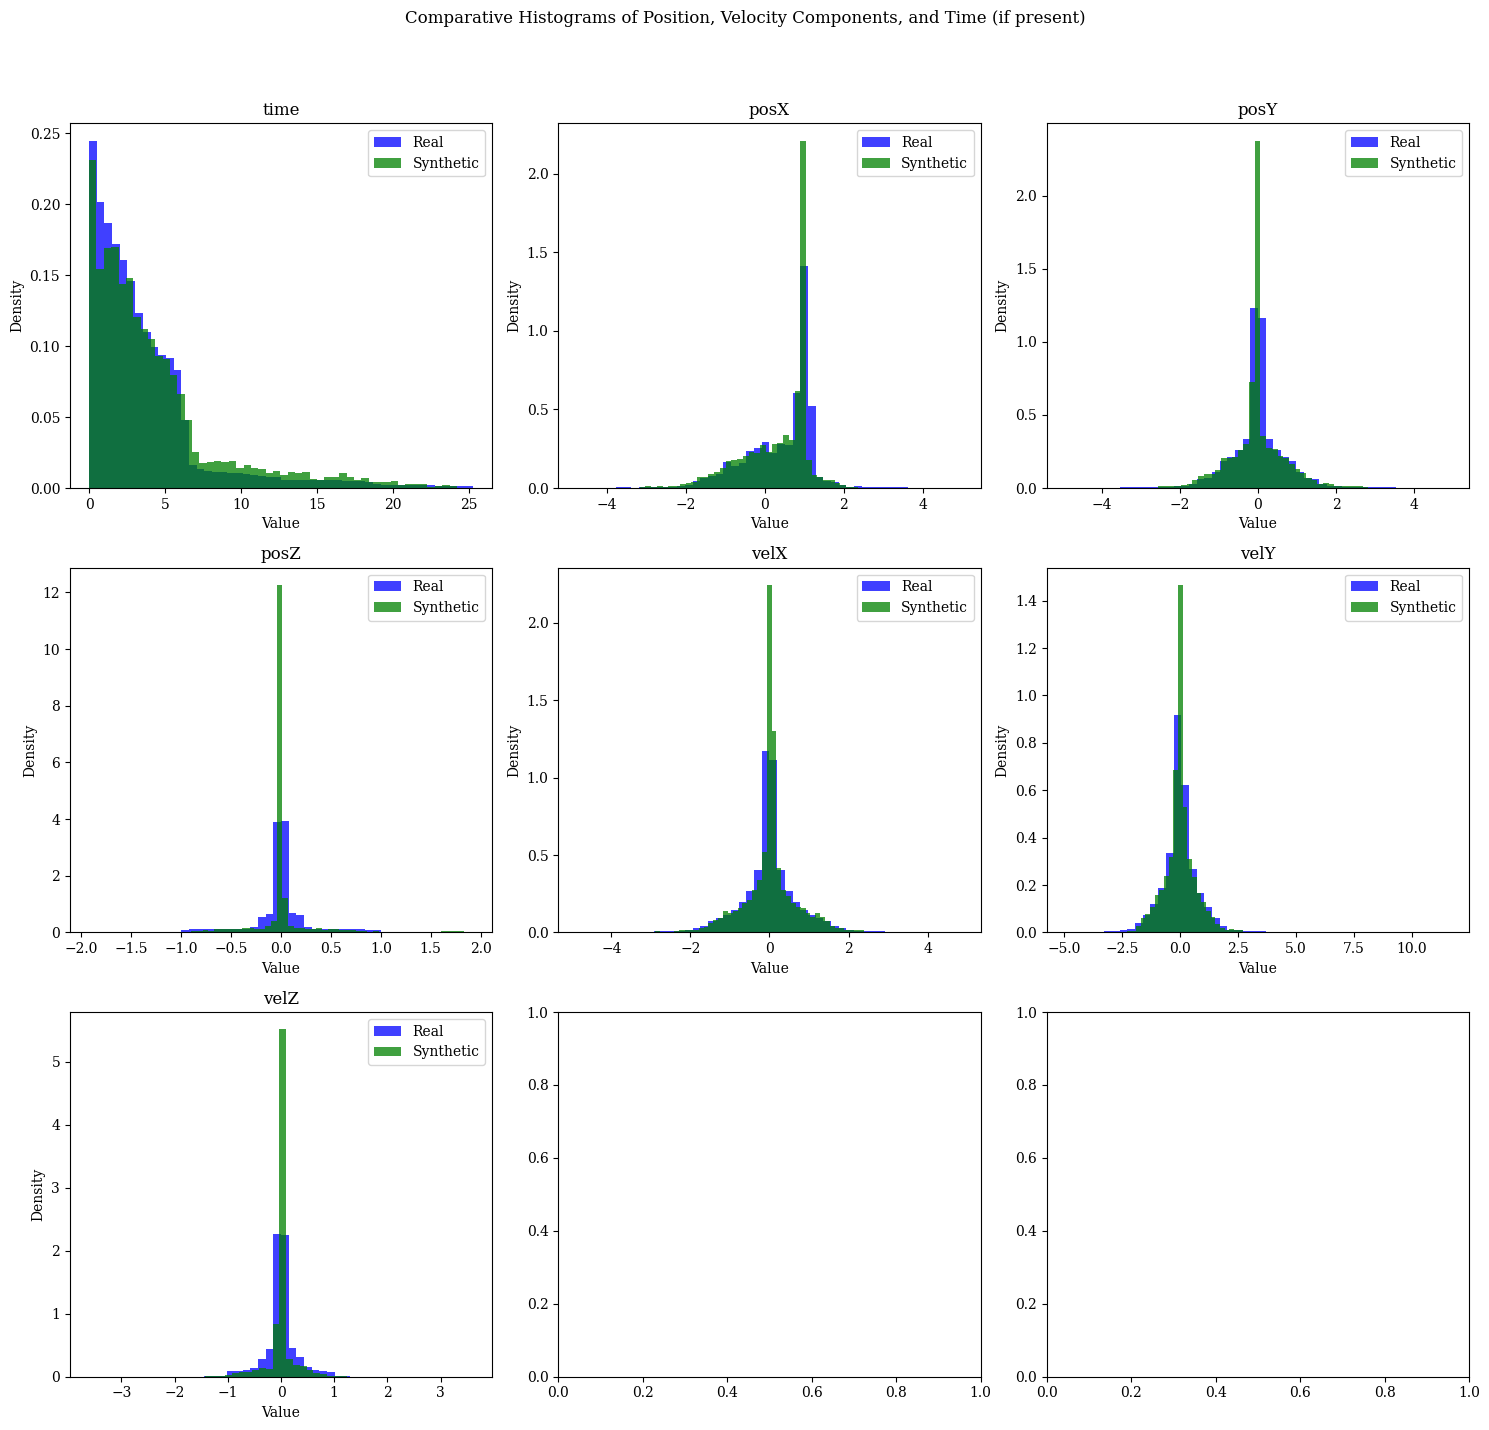

In [20]:
plot_histograms_comparison(data1=data, data2=generation, label1='Real', label2='Synthetic', normalize=True, save_path=histogram_comparison_path)

## Pheasibility

Cumulative position error for selected orbits: 1901.86585181081
Average position error per time step: 19.21076617990717


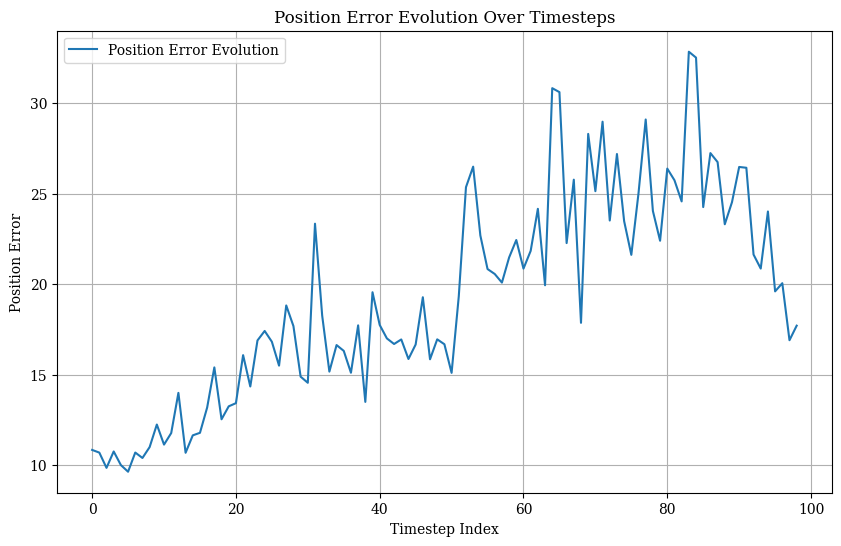

Cumulative velocity error for selected orbits: 3684.5223927462002
Average velocity error per time step: 37.217397906527275


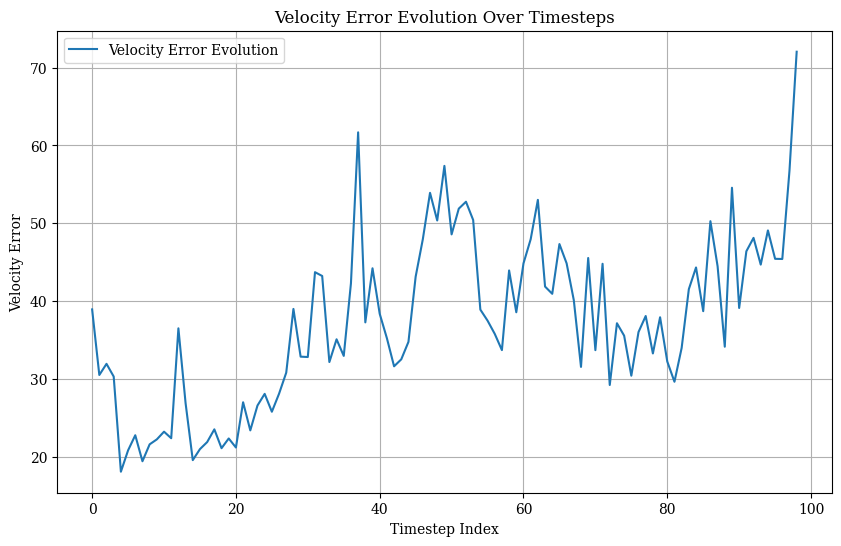

Cumulative energy error for selected orbits: 9383.087890625
Average energy error per time step: 94.7786636352539


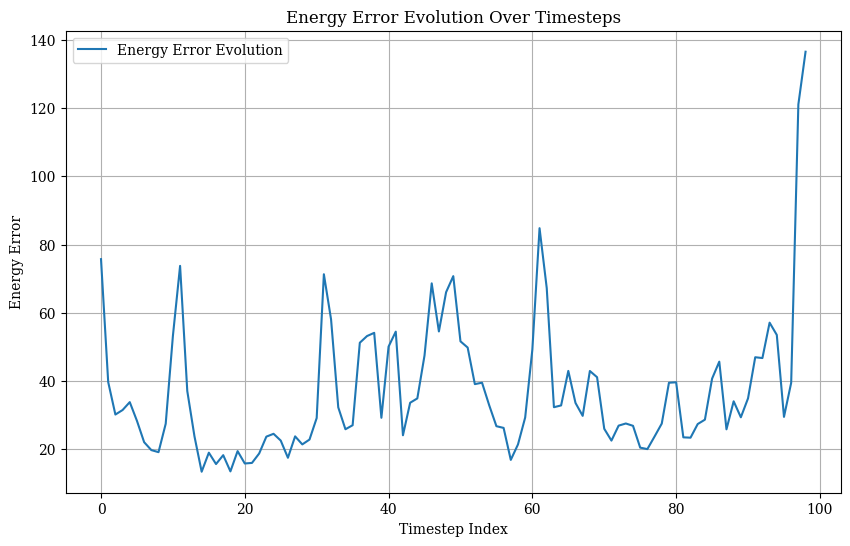

Metrics added to experiment with ID 11 in ../experiments/experiments.json.


In [21]:
if calculate_error_metrics:
    reordered_orbits, order_metrics = reorder_orbits(generation)
    errors = calculate_errors(reordered_orbits,EM_MU)
    add_experiment_metrics(experiments_folder, params=params, metrics={**errors, **order_metrics})

# Latent Space

In [22]:
latent_mean, latent_log_var = model.encode(scaled_data)
latent_mean = latent_mean.detach().numpy()
latent_representation = np.concatenate((latent_mean, latent_log_var.detach().numpy()), axis=1)
np.save(latent_representations_path, latent_representation)
latent_representation.shape

(45211, 4)

In [23]:
orbits_id_classes = [orbit_df.at[index, 'id_class'] for index in labels]
family_labels=get_orbit_classes(orbits_id_classes)[0]

feature_names=['jacobi', 'period', 'stability']
features=orbit_df[feature_names].to_numpy()

## Visualize

Saved plot to ../experiments/experiment_11/images/exp11_latent_space


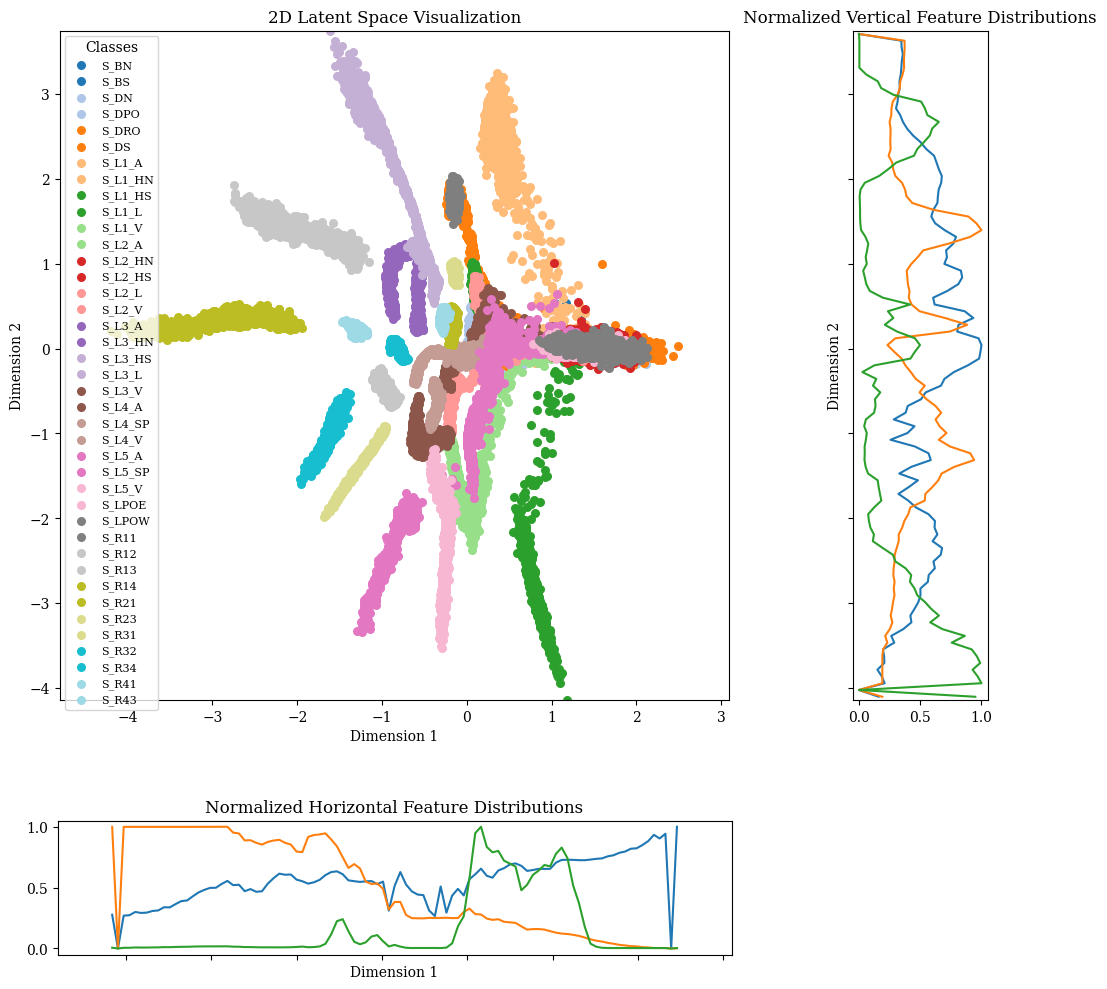

In [24]:
if want_to_generate_latent_space:
    if latent_mean.shape[1]==2:
        plot_2d_latent_space(latent_mean,
                             np.array(family_labels),
                             save_path=latent_space_path,
                             features=features,
                             feature_names=feature_names)
    else:
        rls=reduce_dimensions_latent_space(latent_mean,
                                           np.array(family_labels),
                                           techniques=['PCA','UMAP','t-SNE'],
                                           save_path=latent_space_path,
                                           show_legend=False)


## Clustering

In [25]:
if want_to_get_cluster_metrics:
    cluster_metrics = evaluate_clustering_multiple_labels(latent_mean, [family_labels], label_names=['family'], clustering_method='gmm')
    add_experiment_metrics(experiments_folder, params=params, metrics=cluster_metrics)

Metrics added to experiment with ID 11 in ../experiments/experiments.json.


# Convergence

In [26]:
stop

NameError: name 'stop' is not defined

In [26]:
### make it converge and obtain refined_orbits

In [27]:
# visualize_static_orbits(refined_data[:,:,1:], show_legend=False, save_path=converged_orbits_path)

In [28]:
# export_dynamic_orbits_html(refined_data[:,:,1:], filename=dynamical_refined_orbits_path)

## Metrics

In [29]:
refined_scaled_data = scaler.transform(refined_data)
refined_latent_means, refined_latent_log_vars = model.encode(refined_scaled_data)
refined_latent_representations = latent_mean.numpy()
refined_latent_representations.shape

NameError: name 'refined_data' is not defined

## Latent Space

In [ ]:
if want_to_study_converged_orbits:
    if latent_mean.shape[1]>2:
        rls=reduce_dimensions_latent_space(train_latent=latent_representation,
                                           val_latent=refined_latent_representations)
        latent_representation=rls['PCA']['train']
        refined_latent_representations=rls['PCA']['val']

    plot_combined_2d_latent_space(
        real_latent=latent_representation, 
        synthetic_latent=refined_latent_representations,
        synthetic_labels=list(range(0, len(refined_scaled_data))),
        annotation_mode='numbers',
        save_path=combined_latent_space_path
    )


## Check Novelty

Calculate Jacobi Constant on the dataset

In [ ]:
### array should be (45211, 300, 6)

In [ ]:
results = np.array([jacobi_constant(full_data[i][0], EM_MU)[0] for i in range(full_data.shape[0])])
orbit_df['calculated_jacobi'] = results

orbit_df.head()

Calculate Jacobi Constant and Period on the Refined Orbits

In [ ]:
new_jacobis = np.array([jacobi_constant(display_generation[i][0], EM_MU)[0] for i in range(display_generation.shape[0])])
synthetic_orbit_df['calculated_jacobi'] = new_jacobis
synthetic_orbit_df.rename(columns={'new_period': 'period'}, inplace=True)

synthetic_orbit_df.head()

Compare

In [ ]:
# Define the features to be used for distance calculation
features = ['period', 'calculated_jacobi']

# Calculate the distances
distances = calculate_closest_feature_distances(orbit_df, synthetic_orbit_df, features)

In [ ]:
distances